# CNN

## The project process

### 1. Prepare the data
### 2. Build the model
### 3. Train the model
### 4. Analyse the model's result

#### For preparation of the data, we will use the ETL process: Extract, Transform and Load.

In [1]:
import torch 
import torch.nn as nn
import torchvision.datasets as dsets
import torch.nn.functional as F
import torch.optim as optim
# from skimage import transform
import torchvision.transforms as transforms
from torch.autograd import Variable
import pandas as pd;
import numpy as np;
from torch.utils.data import Dataset, DataLoader
# from vis_utils import *
import random;
import math;

#### Now Fashion MNIST Data set

In [2]:
class FashionMNISTDataset(Dataset):
    '''Fashion MNIST Dataset'''
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file
            transform (callable): Optional transform to apply to sample
        """
        
        data = pd.read_csv(csv_file);
        self.X = np.array(data.iloc[:, 1:]).reshape(-1, 1, 28, 28)#.astype(float);
        self.Y = np.array(data.iloc[:, 0]);
        
        del data;
        self.transform = transform;
        
    def __len__(self):
        return len(self.X);
    
    def __getitem__(self, idx):
        item = self.X[idx];
        label = self.Y[idx];
        
        if self.transform:
            item = self.transform(item);
        
        return (item, label);


In [3]:
train_dataset = FashionMNISTDataset(csv_file='fashionmnist/fashion-mnist_train.csv')

In [4]:
test_dataset = FashionMNISTDataset(csv_file='fashionmnist/fashion-mnist_test.csv')

#### HYPER PARAMETERS

In [5]:
num_epochs = 5;
batch_size = 100;
learning_rate = 0.001;

In [6]:
train_loader = torch.utils.data.DataLoader(
                dataset=train_dataset, batch_size=batch_size,
                shuffle=True
)

test_loader = torch.utils.data.DataLoader(
                dataset=test_dataset, batch_size=batch_size,
                shuffle=True
)

In [7]:
import numpy as np
import matplotlib.pyplot as plt


In [8]:
torch.set_printoptions(linewidth=120)

In [9]:
len(train_dataset)

60000

In [10]:
sample = next(iter(train_dataset)) #using next method with iterate, we can get the next item

In [11]:
len(sample)

2

In [12]:
type(sample)

tuple

In [13]:
image, label = sample

In [14]:
label

2

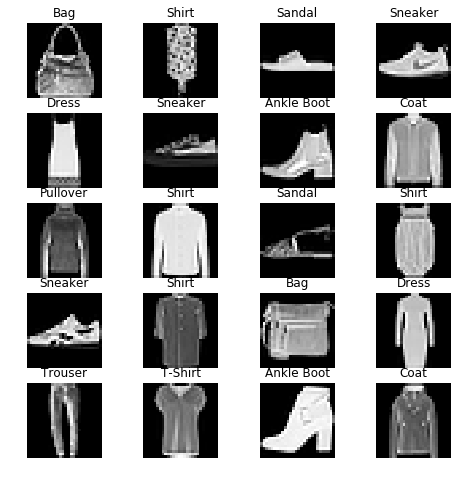

In [15]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [16]:
len(train_dataset)

60000

In [17]:
image.shape

(1, 28, 28)

In [18]:
batch = next(iter(train_loader))

In [19]:
image, labels = batch

In [20]:
image.shape
# 100 because we consider the batch size of 100

torch.Size([100, 1, 28, 28])

#### 100 for the batch size and 1 for the color channel 

In [21]:
labels.shape

torch.Size([100])

### Model

#### Dummy Network

Keep in mind to always extend nn.Module

write the layers

and implement the forward method

In [22]:
class Network(nn.Module):
    def __init__(self):
        # initialization of the super class nn.Module
        # This transforms the simple Network to the pytorch Network
        super(Network,self).__init__()
        self.layer = None
        # We implemented the 2 conv layers 
        # output channels are the number of filters
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        # # fully connected or Dense layers
        # Last 10 corresponds to the number of output classes
        self.fc1 = nn.Linear(in_features=12 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
    # taking tensor t and transforming it with the layer 
    def forward(self,t):
        # Input Layer(1)
        t = t.float()
        
        # Hidden Layer Conv(2)
        t = self.conv1(t)
        # No weights are required in activation function so directly calling from the nn.functional
        t = F.relu(t)
        t = F.max_pool2d(t,kernel_size = 2, stride = 2)
        
        # Hidden Layer Conv(3)
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t,kernel_size = 2, stride = 2)
        
        # Hidden Linear layer (4)
        t = t.reshape(-1,12*4*4)
        # This 4*4 is because of the convolution opn
        t = self.fc1(t)
        t = F.relu(t)
        
        # Hidden Linear layer (5)
        t = self.fc2(t)
        t = F.relu(t)
        
        #last Layer (6)
        t = self.out(t)
        # We wont use the softmax function because we uses the same in the cross entropy loss
        
        return t

In [23]:
network = Network()
network

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)

In [24]:
network.conv1

Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))

In [25]:
network.conv1.weight

Parameter containing:
tensor([[[[ 0.0925, -0.0680,  0.0697,  0.0361, -0.0930],
          [-0.1814, -0.1077,  0.1686,  0.0352,  0.0591],
          [-0.1942,  0.0966, -0.1307,  0.0733,  0.1896],
          [ 0.0399,  0.1819, -0.0208, -0.1450, -0.1033],
          [-0.1091, -0.0623, -0.1473,  0.0133, -0.1085]]],


        [[[ 0.1978, -0.1931,  0.0960,  0.1665,  0.0505],
          [ 0.0256, -0.0688,  0.0967,  0.0342,  0.1422],
          [ 0.1562,  0.0150, -0.0189,  0.0642,  0.0845],
          [ 0.1315, -0.1347,  0.1665, -0.1928,  0.0291],
          [ 0.1178,  0.0991, -0.1001,  0.1164,  0.1873]]],


        [[[ 0.0972,  0.1075, -0.1904,  0.1190,  0.1524],
          [-0.1738,  0.0133,  0.1973, -0.1463, -0.0235],
          [-0.0421,  0.1672,  0.1411,  0.1377, -0.1801],
          [ 0.1788, -0.0792,  0.1493,  0.0932,  0.1549],
          [ 0.1672,  0.1422,  0.0730, -0.0380, -0.1658]]],


        [[[ 0.0470,  0.0973,  0.1080,  0.0835,  0.1419],
          [ 0.1471, -0.0920, -0.0935,  0.1308,  0.1349

In [26]:
for name, param in network.named_parameters():
    print(name, '\t\t', param.shape)

conv1.weight 		 torch.Size([6, 1, 5, 5])
conv1.bias 		 torch.Size([6])
conv2.weight 		 torch.Size([12, 6, 5, 5])
conv2.bias 		 torch.Size([12])
fc1.weight 		 torch.Size([120, 192])
fc1.bias 		 torch.Size([120])
fc2.weight 		 torch.Size([60, 120])
fc2.bias 		 torch.Size([60])
out.weight 		 torch.Size([10, 60])
out.bias 		 torch.Size([10])


### Computation graph Feature

Before we being, we are going to turn off PyTorch’s gradient calculation feature. This will stop PyTorch from automatically building a computation graph as our tensor flows through the network.

The computation graph keeps track of the network's mapping by tracking each computation that happens. The graph is used during the training process to calculate the derivative (gradient) of the loss function with respect to the network’s weights.

Since we are not training the network yet, we aren’t planning on updating the weights, and so we don’t require gradient calculations. We will turn this back on when training begins.

This process of tracking calculations happens in real-time, as the calculations occur. Remember back at the beginning of the series, we said that PyTorch uses a dynamic computational graph. We'll now we're turning it off.

Turning it off isn’t strictly necessary but having the feature turned off does reduce memory consumption since the graph isn't stored in memory. This code will turn the feature off. 

In [27]:
torch.set_grad_enabled(False)

### Learning

In [28]:
netowrk = Network()

In [29]:
sample = next(iter(train_dataset))

In [30]:
image, label = sample

In [31]:
image.shape

(1, 28, 28)

In [32]:
### For prediction we first need to have an extra dimension for the batches

In [33]:
type(image)

numpy.ndarray

In [34]:
image = torch.Tensor(image)

In [35]:
image.shape

torch.Size([1, 28, 28])

In [36]:
image.unsqueeze(0).shape

torch.Size([1, 1, 28, 28])

In [37]:
pred = network(image.unsqueeze(0))

In [38]:
pred

tensor([[ 1.2554,  1.1382, -0.1991,  0.8570, -1.7732, -6.2591, -4.4167, -2.3193, -5.6058, -3.2730]])

In [39]:
pred.softmax(dim=1)

tensor([[3.4645e-01, 3.0811e-01, 8.0894e-02, 2.3259e-01, 1.6762e-02, 1.8885e-04, 1.1919e-03, 9.7081e-03, 3.6294e-04,
         3.7409e-03]])

In [40]:
batch =  next(iter(train_loader))

In [41]:
type(batch)

list

In [42]:
images, labels = batch

In [43]:
images.shape

torch.Size([100, 1, 28, 28])

In [44]:
images = images.float()


###  I have made deliberately network to float so that all params can be in float type and passing the float arguement as well viz., images

In [45]:
network = Network()
network = network.float()

In [46]:
pred = network(images)

In [47]:
pred = pred.softmax(dim=1)
pred.argmax(dim=1)

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [48]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [49]:
labels

tensor([7, 5, 6, 2, 1, 6, 5, 3, 6, 5, 7, 3, 6, 5, 2, 1, 8, 4, 5, 9, 3, 1, 7, 3, 5, 8, 4, 0, 3, 8, 6, 9, 9, 1, 1, 7, 0,
        2, 9, 6, 2, 3, 6, 8, 0, 6, 9, 6, 6, 5, 8, 1, 6, 9, 1, 7, 1, 8, 0, 8, 4, 5, 7, 0, 7, 6, 9, 5, 3, 6, 6, 1, 8, 3,
        0, 4, 0, 8, 8, 0, 3, 3, 3, 2, 6, 3, 0, 2, 9, 8, 1, 1, 0, 6, 6, 4, 9, 4, 7, 7])

In [50]:
get_num_correct(pred,labels)

6

### Setting the pytorch's dynamic computational graph feature on

In [51]:
torch.set_grad_enabled(True)

### Calculating the Loss

In [52]:
preds = network(images)

In [53]:
loss = F.cross_entropy(preds,labels)
loss.item()

3.7755141258239746

### Calculating the grad

In [54]:
print(network.conv1.weight.grad)

None


In [55]:
loss.backward() # way of calculating the gradients

In [56]:
print(network.conv1.weight.grad.shape)

torch.Size([6, 1, 5, 5])


### Updating weights

In [57]:
optimizer = optim.Adam(network.parameters(), lr = learning_rate)

In [58]:
loss.item()

3.7755141258239746

In [59]:
get_num_correct(preds,labels)

6

In [60]:
optimizer.step() # updating the weights

In [61]:
preds = network(images)
loss = F.cross_entropy(preds,labels)
loss.item()

2.6014232635498047

In [62]:
get_num_correct(preds,labels)

8

### Final Looping 

In [63]:
for epoch in range(10):

    total_loss = 0
    total_correct = 0

    for batch in train_loader: # Get Batch
        images, labels = batch 

        preds = network(images) # Pass Batch
        loss = F.cross_entropy(preds, labels) # Calculate Loss

        optimizer.zero_grad() # We need to tell pytorch to zero the grads before calculating the new one
                              # otherwise it will start accumulating the gradients
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss
    )

epoch 0 total_correct: 48367 loss: 322.4458987414837
epoch 1 total_correct: 51850 loss: 221.92713372409344
epoch 2 total_correct: 52720 loss: 197.97415134310722
epoch 3 total_correct: 53307 loss: 181.72780223190784
epoch 4 total_correct: 53530 loss: 173.6097243130207
epoch 5 total_correct: 53817 loss: 163.9110891520977
epoch 6 total_correct: 54122 loss: 157.17244110256433
epoch 7 total_correct: 54305 loss: 150.80339427292347
epoch 8 total_correct: 54527 loss: 145.1729844585061
epoch 9 total_correct: 54718 loss: 139.89834471046925


In [64]:
total_correct/len(train_dataset) # Accuracy

0.9119666666666667

## Analyzing CNN Results : Building and Plotting the Confusion Matrix

### Getting Predictions for entire dataset

In [70]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch
        preds = model(images)
        
        all_preds = torch.cat((all_preds,preds),dim=0)
    return all_preds

In [71]:
prediction_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10000)

In [72]:
train_preds = get_all_preds(network,prediction_loader)

In [73]:
train_preds.shape

torch.Size([60000, 10])

In [74]:
print(train_preds.requires_grad) # it shows that even we are not using the gradient features still gradient tracking is on.


False


#### we can make this off by using 

with torch.no_grad():
        prediction_loader = ....
        train_preds = .....
#### or simply 

writing this annotation 

@torch.no_grad() ------ This ensures that whenever the function is called locally it will turnoff the gradient tracking feature
def get_all_pred()


In [75]:
train_dataset = torch.tensor(train_dataset)

TypeError: not a sequence

In [76]:
type(train_dataset)

__main__.FashionMNISTDataset

In [77]:
train_dataset.targets

AttributeError: 'FashionMNISTDataset' object has no attribute 'targets'

In [78]:
train_dataset

In [85]:
targets = torch.tensor(train_dataset.Y)

In [86]:
targets[1]

tensor(9)

In [87]:
len(targets)

60000

In [88]:
predictions_correct = get_num_correct(train_preds, targets)

In [89]:
predictions_correct/len(targets)

0.9237166666666666

### Building the confusion matrix

In [90]:
targets

tensor([2, 9, 6,  ..., 8, 8, 7])

In [92]:
train_preds.argmax(dim=1)

tensor([2, 9, 4,  ..., 8, 8, 7])

In [93]:
stacked = torch.stack(
        (targets,train_preds.argmax(dim=1)),
    dim=1
)

In [94]:
stacked.shape

torch.Size([60000, 2])

In [95]:
stacked

tensor([[2, 2],
        [9, 9],
        [6, 4],
        ...,
        [8, 8],
        [8, 8],
        [7, 7]])

In [96]:
stacked[0].tolist()

[2, 2]

#### Now for building the confusion matrix we will use the tolist function to get the indices and 10x10 matrix

In [97]:
cmt = torch.zeros(10,10,dtype=torch.int32)
cmt

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)

In [98]:
for p in stacked:
    i, j = p.tolist()
    cmt[i, j] = cmt[i, j]+1

In [99]:
cmt

tensor([[5665,    3,   31,   72,   21,    2,  202,    0,    4,    0],
        [   6, 5944,    2,   33,    9,    0,    5,    0,    1,    0],
        [ 110,    1, 5173,   43,  418,    0,  251,    1,    3,    0],
        [ 148,   29,   13, 5620,  136,    0,   52,    0,    2,    0],
        [  15,    1,  277,  155, 5339,    0,  211,    0,    2,    0],
        [   0,    0,    0,    0,    0, 5934,    0,   50,    0,   16],
        [ 932,    4,  363,  117,  424,    1, 4150,    0,    9,    0],
        [   0,    0,    0,    0,    0,   18,    0, 5894,    0,   88],
        [  22,    0,   12,    9,   20,    9,   34,    4, 5886,    4],
        [   0,    0,    0,    0,    0,    9,    0,  173,    0, 5818]], dtype=torch.int32)

### Plotting the confusion Matrix

#### We already builf the plot_com.py file that contains the plot_confusion_matrix method
 just need to import it; that's it

In [102]:
from plot_com import plot_confusion_matrix

In [103]:
names = (
    'T-shirt/top'
    ,'Trouser'
    ,'Pullover'
    ,'Dress'
    ,'Coat'
    ,'Sandal'
    ,'Shirt'
    ,'Sneaker'
    ,'Bag'
    ,'Ankle boot'
)

In [104]:
plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

Confusion matrix, without normalization
tensor([[5665,    3,   31,   72,   21,    2,  202,    0,    4,    0],
        [   6, 5944,    2,   33,    9,    0,    5,    0,    1,    0],
        [ 110,    1, 5173,   43,  418,    0,  251,    1,    3,    0],
        [ 148,   29,   13, 5620,  136,    0,   52,    0,    2,    0],
        [  15,    1,  277,  155, 5339,    0,  211,    0,    2,    0],
        [   0,    0,    0,    0,    0, 5934,    0,   50,    0,   16],
        [ 932,    4,  363,  117,  424,    1, 4150,    0,    9,    0],
        [   0,    0,    0,    0,    0,   18,    0, 5894,    0,   88],
        [  22,    0,   12,    9,   20,    9,   34,    4, 5886,    4],
        [   0,    0,    0,    0,    0,    9,    0,  173,    0, 5818]], dtype=torch.int32)


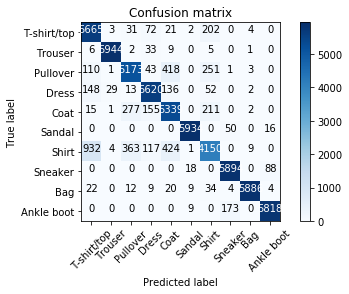

In [105]:
plot_confusion_matrix(cmt, names)